# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

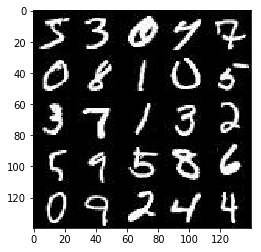

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

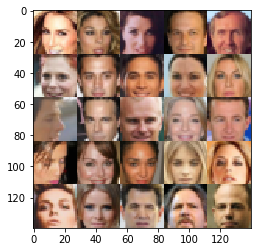

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


D:\install\Continuum\anaconda3\envs\dlnd\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [2]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)) 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    lr = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [3]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), 0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.nn.dropout(tf.maximum(alpha * bn2, bn2), 0.8)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.nn.dropout(tf.maximum(alpha * bn3, bn3), 0.8)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [4]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=False if is_train else True):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        #print(logits.shape)
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # generator output range [-1, 1] while real image [-0.5, 0.5], need rescale
                batch_images = batch_images * 2
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 9, inputs_z, data_shape[3], data_image_mode)
    return losses


### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.7464... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 1.7386
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 1.4104
Epoch 1/2... Discriminator Loss: 0.8070... Generator Loss: 1.5954
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.5666
Epoch 1/2... Discriminator Loss: 0.8143... Generator Loss: 1.5367
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 1.4289
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.2601
Epoch 1/2... Discriminator Loss: 0.5907... Generator Loss: 1.9842
Epoch 1/2... Discriminator Loss: 0.6459... Generator Loss: 1.7947


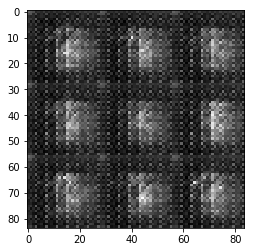

Epoch 1/2... Discriminator Loss: 0.5208... Generator Loss: 2.2372
Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 2.0454
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 1.3053
Epoch 1/2... Discriminator Loss: 0.6795... Generator Loss: 2.1045
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.8779
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.8465
Epoch 1/2... Discriminator Loss: 0.7195... Generator Loss: 3.1250
Epoch 1/2... Discriminator Loss: 0.6965... Generator Loss: 1.4670
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 2.4073
Epoch 1/2... Discriminator Loss: 0.5491... Generator Loss: 1.9179


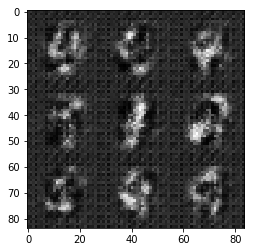

Epoch 1/2... Discriminator Loss: 0.6476... Generator Loss: 1.4720
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.5560... Generator Loss: 2.4215
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 2.7802
Epoch 1/2... Discriminator Loss: 0.5549... Generator Loss: 2.6730
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 4.6561
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 2.9942
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 2.8425
Epoch 1/2... Discriminator Loss: 0.5467... Generator Loss: 2.3749
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 3.2707


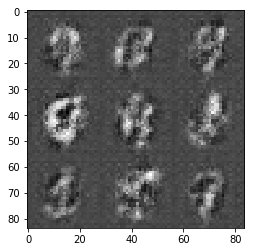

Epoch 1/2... Discriminator Loss: 0.4530... Generator Loss: 2.9826
Epoch 1/2... Discriminator Loss: 0.4786... Generator Loss: 3.7724
Epoch 1/2... Discriminator Loss: 0.4769... Generator Loss: 3.0256
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 2.0812
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.8764
Epoch 1/2... Discriminator Loss: 1.1530... Generator Loss: 0.6875
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 3.0764
Epoch 1/2... Discriminator Loss: 0.4865... Generator Loss: 2.8954
Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 1.8897
Epoch 1/2... Discriminator Loss: 0.5148... Generator Loss: 2.2148


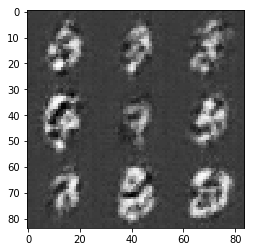

Epoch 1/2... Discriminator Loss: 0.5764... Generator Loss: 3.2792
Epoch 1/2... Discriminator Loss: 0.9656... Generator Loss: 0.8694
Epoch 1/2... Discriminator Loss: 0.6657... Generator Loss: 3.4066
Epoch 1/2... Discriminator Loss: 0.4736... Generator Loss: 2.3132
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 2.8574
Epoch 1/2... Discriminator Loss: 0.4601... Generator Loss: 3.2963
Epoch 2/2... Discriminator Loss: 0.4833... Generator Loss: 2.3180
Epoch 2/2... Discriminator Loss: 0.4653... Generator Loss: 2.7982
Epoch 2/2... Discriminator Loss: 0.4545... Generator Loss: 2.6105
Epoch 2/2... Discriminator Loss: 0.4750... Generator Loss: 2.4681


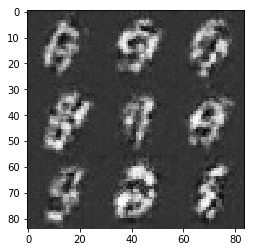

Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 2.8948
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 1.7877
Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 2.9780
Epoch 2/2... Discriminator Loss: 0.4392... Generator Loss: 2.6883
Epoch 2/2... Discriminator Loss: 0.4277... Generator Loss: 3.1811
Epoch 2/2... Discriminator Loss: 0.4460... Generator Loss: 2.5899
Epoch 2/2... Discriminator Loss: 0.4189... Generator Loss: 2.9670
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 3.2223
Epoch 2/2... Discriminator Loss: 0.4402... Generator Loss: 2.6644
Epoch 2/2... Discriminator Loss: 0.4101... Generator Loss: 2.9693


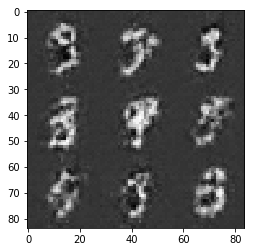

Epoch 2/2... Discriminator Loss: 0.4163... Generator Loss: 2.9188
Epoch 2/2... Discriminator Loss: 0.4026... Generator Loss: 3.2223
Epoch 2/2... Discriminator Loss: 0.4120... Generator Loss: 3.3729
Epoch 2/2... Discriminator Loss: 0.4375... Generator Loss: 2.8658
Epoch 2/2... Discriminator Loss: 0.4219... Generator Loss: 2.8670
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 2.7302
Epoch 2/2... Discriminator Loss: 0.4093... Generator Loss: 3.5651
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.8419
Epoch 2/2... Discriminator Loss: 0.3883... Generator Loss: 3.3474
Epoch 2/2... Discriminator Loss: 0.4238... Generator Loss: 2.7734


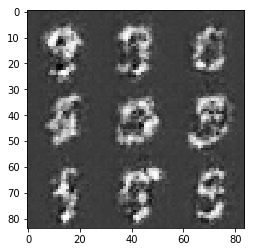

Epoch 2/2... Discriminator Loss: 0.4635... Generator Loss: 2.3824
Epoch 2/2... Discriminator Loss: 0.3725... Generator Loss: 3.7625
Epoch 2/2... Discriminator Loss: 3.3791... Generator Loss: 5.9639
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 2.3196
Epoch 2/2... Discriminator Loss: 0.4359... Generator Loss: 2.9209
Epoch 2/2... Discriminator Loss: 0.4378... Generator Loss: 2.6282
Epoch 2/2... Discriminator Loss: 0.4083... Generator Loss: 2.9421
Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 2.1352
Epoch 2/2... Discriminator Loss: 0.4378... Generator Loss: 2.6134
Epoch 2/2... Discriminator Loss: 0.4252... Generator Loss: 2.7611


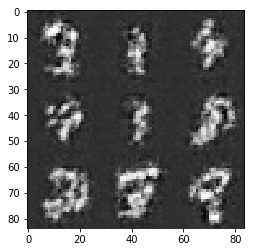

Epoch 2/2... Discriminator Loss: 0.4135... Generator Loss: 2.9398
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 2.8286
Epoch 2/2... Discriminator Loss: 0.4342... Generator Loss: 2.5857
Epoch 2/2... Discriminator Loss: 0.4625... Generator Loss: 2.4718
Epoch 2/2... Discriminator Loss: 0.4623... Generator Loss: 2.3776
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 2.5199
Epoch 2/2... Discriminator Loss: 0.3914... Generator Loss: 3.2373
Epoch 2/2... Discriminator Loss: 0.4154... Generator Loss: 2.8342
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 3.4238
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 1.8504


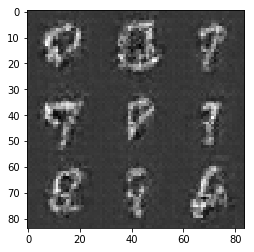

Epoch 2/2... Discriminator Loss: 0.4858... Generator Loss: 2.7190
Epoch 2/2... Discriminator Loss: 0.4665... Generator Loss: 2.5774
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 1.8088


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.9016... Generator Loss: 0.1331
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.4434
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 0.7191... Generator Loss: 1.6327
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 1.9444


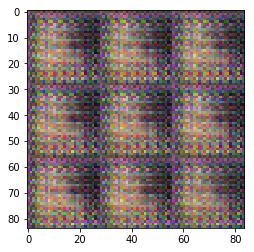

Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 1.7558
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 2.0680
Epoch 1/1... Discriminator Loss: 0.6852... Generator Loss: 1.6660
Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 2.3675
Epoch 1/1... Discriminator Loss: 0.5789... Generator Loss: 2.2535
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 2.5399
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.5717
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 2.8723
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 2.5707
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 2.9024


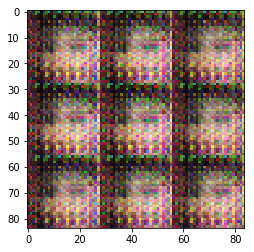

Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 2.5371
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.6315
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 3.7890
Epoch 1/1... Discriminator Loss: 0.4716... Generator Loss: 3.5591
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 3.1355
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.8010
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.7697
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 3.3616
Epoch 1/1... Discriminator Loss: 0.4115... Generator Loss: 3.1171
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 3.0856


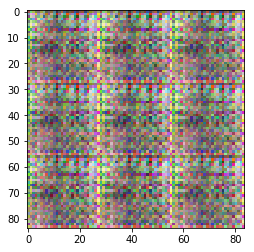

Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 3.1516
Epoch 1/1... Discriminator Loss: 0.3989... Generator Loss: 3.4046
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 3.2120
Epoch 1/1... Discriminator Loss: 0.4180... Generator Loss: 2.8821
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 3.4674
Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 4.0388
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 4.6353
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 2.9878
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 2.6370
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.9954


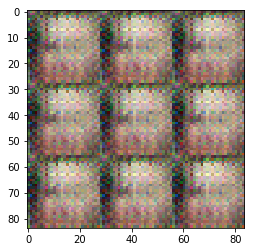

Epoch 1/1... Discriminator Loss: 0.4596... Generator Loss: 2.7140
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 6.9149
Epoch 1/1... Discriminator Loss: 0.5882... Generator Loss: 4.6211
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 3.1337
Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 3.1445
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.5187
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.8953
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.6447


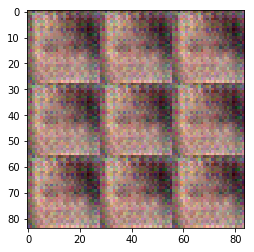

Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 2.4635
Epoch 1/1... Discriminator Loss: 0.4881... Generator Loss: 3.5943
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.4671
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 3.2157
Epoch 1/1... Discriminator Loss: 0.4490... Generator Loss: 2.5313
Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 2.8018
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 4.3385
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 3.8490
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 3.3128
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.4547


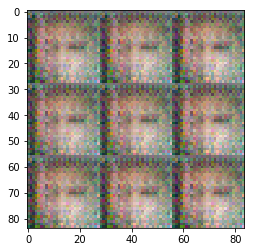

Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 2.9153
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 2.6343
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 3.8354
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 2.8689
Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 3.7350
Epoch 1/1... Discriminator Loss: 0.4388... Generator Loss: 2.7203
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 2.7117
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.9257
Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 3.3614
Epoch 1/1... Discriminator Loss: 0.4337... Generator Loss: 3.6539


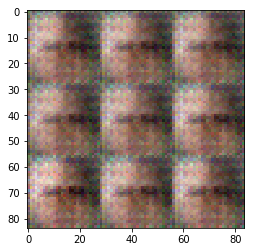

Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 3.0821
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.7939
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 3.3695
Epoch 1/1... Discriminator Loss: 0.4471... Generator Loss: 3.4805
Epoch 1/1... Discriminator Loss: 0.4266... Generator Loss: 3.4215
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 3.4314
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 3.1689
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.7470
Epoch 1/1... Discriminator Loss: 0.5517... Generator Loss: 2.8920
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 2.3088


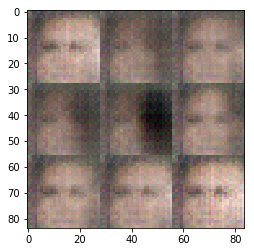

Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 2.1058
Epoch 1/1... Discriminator Loss: 0.5686... Generator Loss: 2.2781
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.4760
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 2.1609
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 2.0767
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 2.2182
Epoch 1/1... Discriminator Loss: 0.5545... Generator Loss: 2.2353
Epoch 1/1... Discriminator Loss: 0.5942... Generator Loss: 1.8866


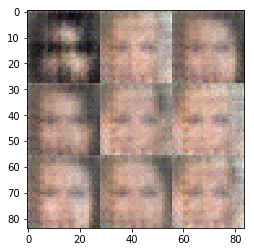

Epoch 1/1... Discriminator Loss: 0.6088... Generator Loss: 1.9659
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.7648
Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.8307
Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 2.3976
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 2.2839
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.5245
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 1.7533
Epoch 1/1... Discriminator Loss: 0.6859... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.2058


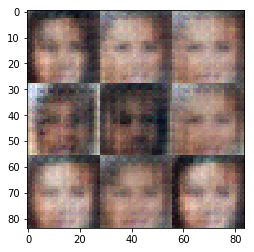

Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 2.0507
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 3.0085
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 3.3291
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 3.4586
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 6.3656
Epoch 1/1... Discriminator Loss: 0.4117... Generator Loss: 3.8749
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 8.6263


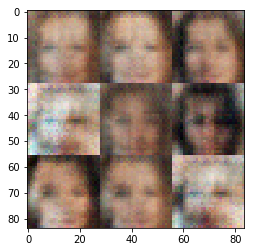

Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 5.2602
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 4.9711
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 5.5238
Epoch 1/1... Discriminator Loss: 0.4495... Generator Loss: 3.0597
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.2553
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 2.5771
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 5.9553
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.5486
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 5.8081
Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 2.4939


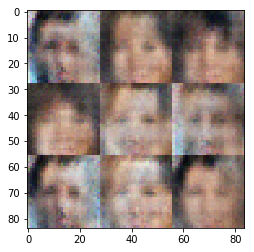

Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 8.0309
Epoch 1/1... Discriminator Loss: 0.3494... Generator Loss: 5.9150
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 3.2461
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 1.1610
Epoch 1/1... Discriminator Loss: 0.4128... Generator Loss: 5.8458
Epoch 1/1... Discriminator Loss: 0.3533... Generator Loss: 8.1480


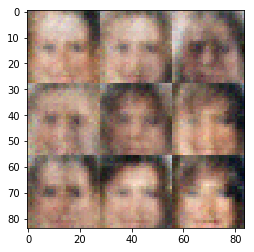

Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 6.6797
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.7291
Epoch 1/1... Discriminator Loss: 0.4158... Generator Loss: 3.0114
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.0245
Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 2.9399
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 7.3064
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 7.3143
Epoch 1/1... Discriminator Loss: 0.5129... Generator Loss: 2.5833
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 2.6148


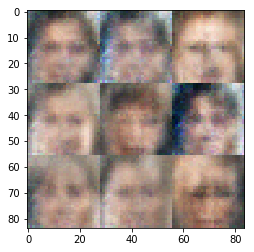

Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 4.2438
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 2.4760
Epoch 1/1... Discriminator Loss: 0.4436... Generator Loss: 2.4921
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 1.9299
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 5.0254
Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.5627
Epoch 1/1... Discriminator Loss: 0.6451... Generator Loss: 6.0952
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.5577
Epoch 1/1... Discriminator Loss: 0.4068... Generator Loss: 3.0090
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 2.9619


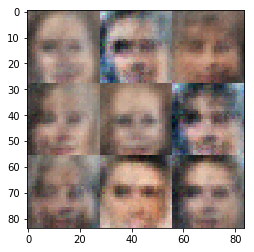

Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 6.4520
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 7.4565
Epoch 1/1... Discriminator Loss: 0.4584... Generator Loss: 2.7165
Epoch 1/1... Discriminator Loss: 0.3718... Generator Loss: 5.9839
Epoch 1/1... Discriminator Loss: 0.4355... Generator Loss: 4.7946
Epoch 1/1... Discriminator Loss: 0.3556... Generator Loss: 5.2766
Epoch 1/1... Discriminator Loss: 0.3876... Generator Loss: 3.4233
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 4.2201


In [30]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。